# Transfer Learning

In [1]:
import logging
import itertools
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (mean_squared_error, r2_score,
                             confusion_matrix, ConfusionMatrixDisplay)
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# Restrict tensorflow output to errors
logging.getLogger('tensorflow').setLevel(logging.ERROR)

# Make this notebook's output stable across runs
random_state = 1000
np.random.seed(random_state)
tf.random.set_seed(random_state)

# Plot formatting
%matplotlib inline
sns.set()
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Train on Fashion MNIST Excluding Bags and Ankle Boots

In [2]:
# Load fashion MNIST data
fashion_mnist = keras.datasets.fashion_mnist

((X_train_full, y_train_full),
    (X_test, y_test)) = fashion_mnist.load_data()

class_names = [
    'T-Shirt or Top', 'Trouser', 'Pullover', 
    'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker'
]

y_train_full.shape

(60000,)

In [3]:
# Drop Sandal and Shirt observations
dropobs = np.in1d(y_train_full, [8, 9])
y_train_full = y_train_full[~dropobs]
X_train_full = X_train_full[~dropobs]

dropobs = np.in1d(y_test, [8, 9])
y_test = y_test[~dropobs]
X_test = X_test[~dropobs]

In [4]:
y_train_full.shape

(48000,)

In [5]:
# Create validation set and scale variables
X_valid = X_train_full[:5000] / 255.0
X_train = X_train_full[5000:] / 255.0
y_valid = y_train_full[:5000]
y_train = y_train_full[5000:]
X_test = X_test / 255.0 

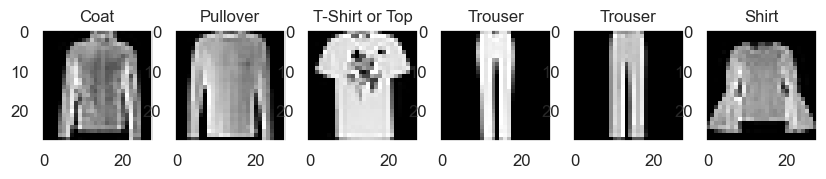

In [6]:
# Output random training instances as images
fig, axs = plt.subplots(1, 6, figsize=(10, 4))
locs = np.random.randint(0, 5000, 6)
for i, ax in enumerate(axs):
    ax.imshow(X_train[locs[i]], cmap='gray')
    ax.set_title(class_names[y_train[locs[i]]])
    ax.grid(False)

plt.show()

In [7]:
# Create a model with two hidden layers
tf.keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = X_train[0].shape))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(len(class_names), activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 8)                 808       
                                                                 
Total params: 266,408
Trainable params: 266,408
Non-trainable params: 0
_________________________________________________________________


In [8]:
# Fit the model
model.compile(loss='sparse_categorical_crossentropy',
              optimizer='sgd', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                    validation_data=(X_valid, y_valid))

Epoch 1/30
   1/1344 [..............................] - ETA: 3:55 - loss: 2.0811 - accuracy: 0.1875

2023-03-07 11:40:32.407949: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


1344/1344 [==============================] - 2s 1ms/step - loss: 0.7239 - accuracy: 0.7492 - val_loss: 0.5524 - val_accuracy: 0.8038
Epoch 2/30
1344/1344 [==============================] - 2s 1ms/step - loss: 0.5103 - accuracy: 0.8153 - val_loss: 0.4658 - val_accuracy: 0.8300
Epoch 3/30
1344/1344 [==============================] - 2s 1ms/step - loss: 0.4651 - accuracy: 0.8300 - val_loss: 0.4476 - val_accuracy: 0.8358
Epoch 4/30
1344/1344 [==============================] - 2s 1ms/step - loss: 0.4389 - accuracy: 0.8397 - val_loss: 0.4185 - val_accuracy: 0.8498
Epoch 5/30
1344/1344 [==============================] - 1s 1ms/step - loss: 0.4182 - accuracy: 0.8462 - val_loss: 0.4083 - val_accuracy: 0.8532
Epoch 6/30
1344/1344 [==============================] - 2s 1ms/step - loss: 0.4020 - accuracy: 0.8534 - val_loss: 0.4039 - val_accuracy: 0.8516
Epoch 7/30
1344/1344 [==============================] - 1s 1ms/step - loss: 0.3893 - accuracy: 0.8575 - val_loss: 0.3896 - val_accuracy: 0.8584
Epo

In [9]:
# Evaluate on the test data
model.evaluate(X_test, y_test)

250/250 [==============================] - 0s 616us/step - loss: 0.3497 - accuracy: 0.8730


[0.3496592342853546, 0.8730000257492065]

In [10]:
model.save('fashion_mnist.h5')

250/250 [==============================] - 0s 512us/step


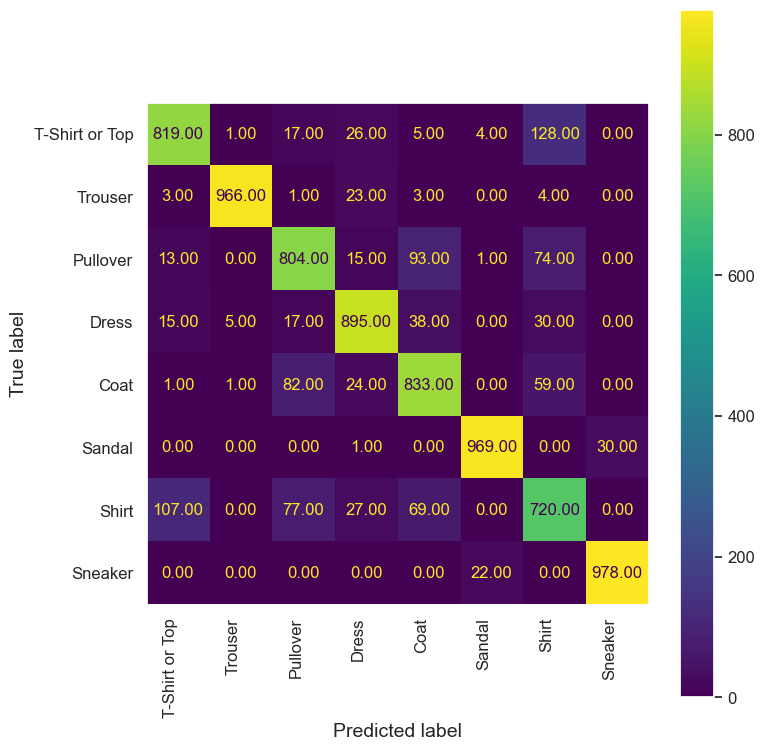

In [11]:
# Calculate a confusion matrix
y_pred = np.argmax(model.predict(X_test), axis=1)
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))

cmdisplay = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmdisplay.plot(values_format='.2f', ax=ax)

plt.grid(visible=None)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

# Train on Only Bags and Ankle Boots

In [12]:
# Load fashion MNIST data
fashion_mnist = keras.datasets.fashion_mnist

((X_train_full, y_train_full),
    (X_test, y_test)) = fashion_mnist.load_data()

class_names = ['Bag', 'Ankle Boot']

y_train_full.shape

(60000,)

In [13]:
# Keep Sandal and Shirt observations
keepobs = np.in1d(y_train_full, [8, 9])
y_train_full = y_train_full[keepobs]
X_train_full = X_train_full[keepobs]

keepobs = np.in1d(y_test, [8, 9])
y_test = y_test[keepobs]
X_test = X_test[keepobs]

In [14]:
y_train_full.shape

(12000,)

In [15]:
# Fix label numbers
def fix_label_number(x):
    return x - 8
    
vect_fix_label_number = np.vectorize(fix_label_number)

y_train_full = vect_fix_label_number(y_train_full)
y_test = vect_fix_label_number(y_test)

In [16]:
# Create validation set and scale variables
X_valid = X_train_full[:11980] / 255.0
X_train = X_train_full[11980:] / 255.0
y_valid = y_train_full[:11980]
y_train = y_train_full[11980:]
X_test = X_test / 255.0 

In [17]:
y_train.shape

(20,)

In [18]:
np.bincount(y_train)

array([11,  9])

In [19]:
# Create a model with two hidden layers
tf.keras.backend.clear_session()

model = keras.models.Sequential()
model.add(keras.layers.Flatten(input_shape = X_train[0].shape))
model.add(keras.layers.Dense(300, activation='relu'))
model.add(keras.layers.Dense(100, activation='relu'))
model.add(keras.layers.Dense(1, activation='sigmoid'))

model.summary() 

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 dense_2 (Dense)             (None, 1)                 101       
                                                                 
Total params: 265,701
Trainable params: 265,701
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Fit the model
model.compile(loss='binary_crossentropy',
              optimizer='sgd', metrics=['accuracy'])

history = model.fit(X_train, y_train, epochs=10, batch_size=32,
                    validation_data=(X_valid, y_valid))

Epoch 1/10
1/1 [==============================] - 0s 455ms/step - loss: 0.7659 - accuracy: 0.4500 - val_loss: 0.6592 - val_accuracy: 0.6391
Epoch 2/10
1/1 [==============================] - 0s 187ms/step - loss: 0.6464 - accuracy: 0.6000 - val_loss: 0.6270 - val_accuracy: 0.7563
Epoch 3/10
1/1 [==============================] - 0s 190ms/step - loss: 0.5851 - accuracy: 0.9500 - val_loss: 0.6049 - val_accuracy: 0.8096
Epoch 4/10
1/1 [==============================] - 0s 186ms/step - loss: 0.5468 - accuracy: 1.0000 - val_loss: 0.5859 - val_accuracy: 0.8411
Epoch 5/10
1/1 [==============================] - 0s 188ms/step - loss: 0.5179 - accuracy: 1.0000 - val_loss: 0.5684 - val_accuracy: 0.8625
Epoch 6/10
1/1 [==============================] - 0s 188ms/step - loss: 0.4929 - accuracy: 1.0000 - val_loss: 0.5513 - val_accuracy: 0.8844
Epoch 7/10
1/1 [==============================] - 0s 189ms/step - loss: 0.4703 - accuracy: 1.0000 - val_loss: 0.5355 - val_accuracy: 0.9023
Epoch 8/10
1/1 [====

In [21]:
model.evaluate(X_test, y_test)

63/63 [==============================] - 0s 564us/step - loss: 0.4927 - accuracy: 0.9395


[0.4927178621292114, 0.9394999742507935]

63/63 [==============================] - 0s 524us/step


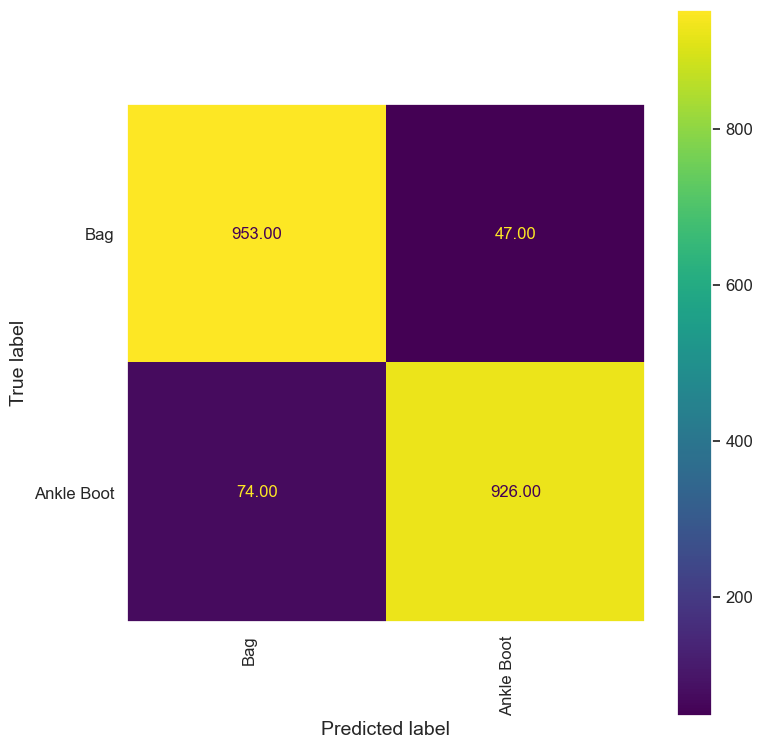

In [22]:
# Display a confusion matrix
y_pred = (model.predict(X_test) > 0.5).astype('int32')
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))

cmdisplay = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmdisplay.plot(values_format='.2f', ax=ax)

plt.grid(visible=None)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()

# Use Transfer Learning on Bags and Ankle Boots

In [23]:
# Load model trained on fashion MNIST classes except shirts and sandals
tf.keras.backend.clear_session()
model_pretrained = keras.models.load_model('fashion_mnist.h5')

In [24]:
# Remove upper layer of pretrained model
model_transfer = keras.models.Sequential(model_pretrained.layers[:-1])
model_transfer.add(keras.layers.Dense(1, name='NewOutput', activation='sigmoid'))

In [25]:
# Freeze lower layers of pretrained model
for layer in model_transfer.layers[:-1]:
    layer.trainable = False 

In [26]:
# Compile model
model_transfer.compile(loss='binary_crossentropy', optimizer='sgd',
                       metrics=['accuracy'])

In [30]:
model_transfer.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 300)               235500    
                                                                 
 dense_1 (Dense)             (None, 100)               30100     
                                                                 
 NewOutput (Dense)           (None, 1)                 101       
                                                                 
Total params: 265,701
Trainable params: 101
Non-trainable params: 265,600
_________________________________________________________________


In [27]:
model_transfer.fit(X_train, y_train, epochs=50,
                   validation_data=(X_valid, y_valid))

Epoch 1/50
1/1 [==============================] - 0s 418ms/step - loss: 0.6358 - accuracy: 0.6000 - val_loss: 0.6370 - val_accuracy: 0.5156
Epoch 2/50
1/1 [==============================] - 0s 188ms/step - loss: 0.4821 - accuracy: 0.6500 - val_loss: 0.5281 - val_accuracy: 0.6459
Epoch 3/50
1/1 [==============================] - 0s 182ms/step - loss: 0.3890 - accuracy: 0.8000 - val_loss: 0.4657 - val_accuracy: 0.8290
Epoch 4/50
1/1 [==============================] - 0s 187ms/step - loss: 0.3355 - accuracy: 0.9500 - val_loss: 0.4293 - val_accuracy: 0.8987
Epoch 5/50
1/1 [==============================] - 0s 184ms/step - loss: 0.3040 - accuracy: 1.0000 - val_loss: 0.4069 - val_accuracy: 0.9167
Epoch 6/50
1/1 [==============================] - 0s 187ms/step - loss: 0.2841 - accuracy: 1.0000 - val_loss: 0.3920 - val_accuracy: 0.9208
Epoch 7/50
1/1 [==============================] - 0s 185ms/step - loss: 0.2705 - accuracy: 1.0000 - val_loss: 0.3812 - val_accuracy: 0.9240
Epoch 8/50
1/1 [====

In [28]:
model_transfer.evaluate(X_test, y_test)

63/63 [==============================] - 0s 535us/step - loss: 0.2479 - accuracy: 0.9650


[0.24793340265750885, 0.9649999737739563]

63/63 [==============================] - 0s 466us/step


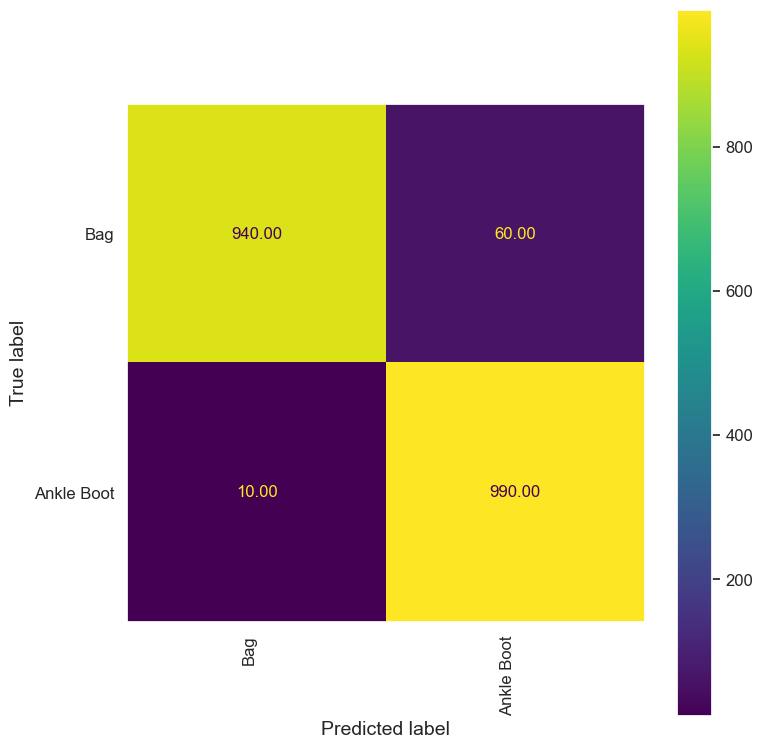

In [29]:
# Display a confusion matrix
y_pred = (model_transfer.predict(X_test) > 0.5).astype('int32')
cm = confusion_matrix(y_test, y_pred)

# Display the confusion matrix
fig, ax = plt.subplots(figsize=(8, 8))

cmdisplay = ConfusionMatrixDisplay(cm, display_labels=class_names)
cmdisplay.plot(values_format='.2f', ax=ax)

plt.grid(visible=None)
plt.xticks(rotation=90, ha='right')
plt.tight_layout()
plt.show()